In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import copy
from datetime import datetime


print("imported modules")

imported modules


In [ ]:
# configuration
start_post = 0
end_post = 42000

In [2]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


In [3]:
def get_date(data_string):
    date = datetime.date(datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S'))
    year = pd.Timestamp(date).year
    quarter = pd.Timestamp(date).quarter
    return year, quarter

def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

In [4]:
def vectorizer_with_threshold(text_vectorizer):
    threshold = 0.3
    vec = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= threshold]
    return vec

def vectorizer_top_n_words(text_vectorizer):    
    n = 3
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]        
    return vec


def vectorizer_top_n_percent(text_vectorizer, vec_len):
    percent = 0.15
    #vec_len = len(vectorizer.get_feature_names())
    n = int(vec_len * percent)
    
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]            
    return vec

In [5]:
def get_relevant_words(text):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.5)
    try:
        text_vectorizer = vectorizer.fit_transform([text])
    except:        
        return False
    relevant_words = []    
    feature_array = np.array(vectorizer.get_feature_names())

    #tfidf_bigger_than = vectorizer_with_threshold(text_vectorizer)
    #tfidf_bigger_than = vectorizer_with_n_words(text_vectorizer)
    tfidf_bigger_than = vectorizer_top_n_percent(text_vectorizer, len(feature_array))
    relevant_words.append(feature_array[tfidf_bigger_than])
    return relevant_words
    
def add_words_to_counter(relevant_words, filtered_spans, year, quarter):    
    for word in relevant_words[0]:          
        for span in filtered_spans:            
            if word in span.text:    
                topic_frequency_dict[year][quarter][span.lemma_] += 1

In [6]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'OP': '+', 'POS': 'NOUN'},
           {'POS': 'NOUN', 'OP': '?'}
          ]

matcher.add("match_topic1", [topic_pattern1])

word_set = set()
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'
post_df = pd.DataFrame(stack_posts[["QuestionId", "QuestionDate", "QuestionBody", "AnswerId", "AnswerBody", "AnswerDate"]][0:end_post])


# initialize topic frequency counter
topic_frequency_dict = dict()
for year in range(2015, 2022):
    topic_frequency_dict[year] = dict()
    for quarter in range(1, 5):
        topic_frequency_dict[year][quarter] = Counter()
        
for i, line in enumerate(post_df.itertuples()):
    post = pd.DataFrame(line).transpose().drop(0, axis=1)
    post.columns = post_df.columns
    
    # analyze questions    
    if post["QuestionId"][0] != post_df.iloc[i - 1]["QuestionId"]:            
        text = clean_bodys(post["QuestionBody"][0])
        doc = nlp(text)
        matches = matcher(doc)
        
        filtered_spans = filter_spans(matches)
        relevant_words = get_relevant_words(text)
        if relevant_words == False:
            continue
        
        year, quarter = get_date(post["QuestionDate"][0])
        add_words_to_counter(relevant_words, filtered_spans, year, quarter)        
    
    # analyze answers
    text = clean_bodys(post["AnswerBody"][0])      
    doc = nlp(text)        
    matches = matcher(doc)
    
    filtered_spans = filter_spans(matches)    
    relevant_words = get_relevant_words(text)
    if relevant_words == False:
        continue
    
    year, quarter = get_date(post["AnswerDate"][0])   
    add_words_to_counter(relevant_words, filtered_spans, year, quarter)
    
print("finished")

finished


In [ ]:
topic_frequency_df = pd.DataFrame.from_dict(topic_frequency_dict).transpose()
topic_counter = Counter()

for year in topic_frequency_df:
    for quarter in topic_frequency_df[year]:
        topic_counter = sum((topic_counter, quarter), Counter())

#bigger_than_x_counter = Counter({k: c for k,c in topic_counter.items() if c >= 50})
#sorted_counter = bigger_than_x_counter.most_common()
#df = pd.DataFrame.from_dict(topic_frequency_dict, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False)
#topic_frequency_dict
#plt.style.use('fivethirtyeight')

#figure = df.plot(kind = 'bar', figsize=(25, 25))
#figure.set_xlabel("Wort")
#figure.set_ylabel("Häufigkeit")

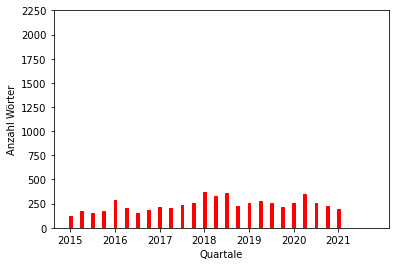

In [18]:
i = 0
for year in topic_frequency_dict:    
    for quarter in topic_frequency_dict[year]:
        plt.bar(i, topic_frequency_dict[year][quarter]["class"], color='#ff0000', width=0.25, edgecolor='red')
        i += 1        

plt.xlabel('Quartale')
plt.ylabel('Anzahl Wörter')
plt.xticks([x * 4 for x in range(2022-2015)], [year for year in range(2015, 2022)])
plt.yticks([y * 250 for y in range(0,10)])
plt.show()